# Fine-tuning SmolVLM on ChartLlama Dataset (Plotting part)

This notebook demonstrates how to fine-tune the SmolVLM model on the ChartLlama dataset using parameter-efficient fine-tuning (LoRA).

### Plotting the loss curve

In [1]:
# --- Standard Libraries ---
import os, sys, gc, time, json, re, math, string, traceback
from pathlib import Path
from functools import reduce
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union
from itertools import islice

# --- Data Science & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from cycler import cycler

# --- Image Processing ---
from PIL import Image

# --- Data Handling & Utils ---
#from word2number import w2n

In [2]:
WORKING_DIR = './smolvlm-chartllama-sft-final_base_trainer_states'
BASE_OUTPUT_DIR = Path(WORKING_DIR)
OUTPUT_DIR_BASE_NAME = "smolvlm-chartllama-sft-final"
OUTPUT_FOLDER_PREFIX = OUTPUT_DIR_BASE_NAME

--- Plotting Base Runs ---


/var/folders/4p/mxc4bjj17l30j58yqmwv8jy00000gn/T/ipykernel_17048/3354775316.py:173: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.95])


Enhanced plot saved to smolvlm-chartllama-sft-final_base_trainer_states/smolvlm-chartllama-sft-final_base_loss_curves.pdf


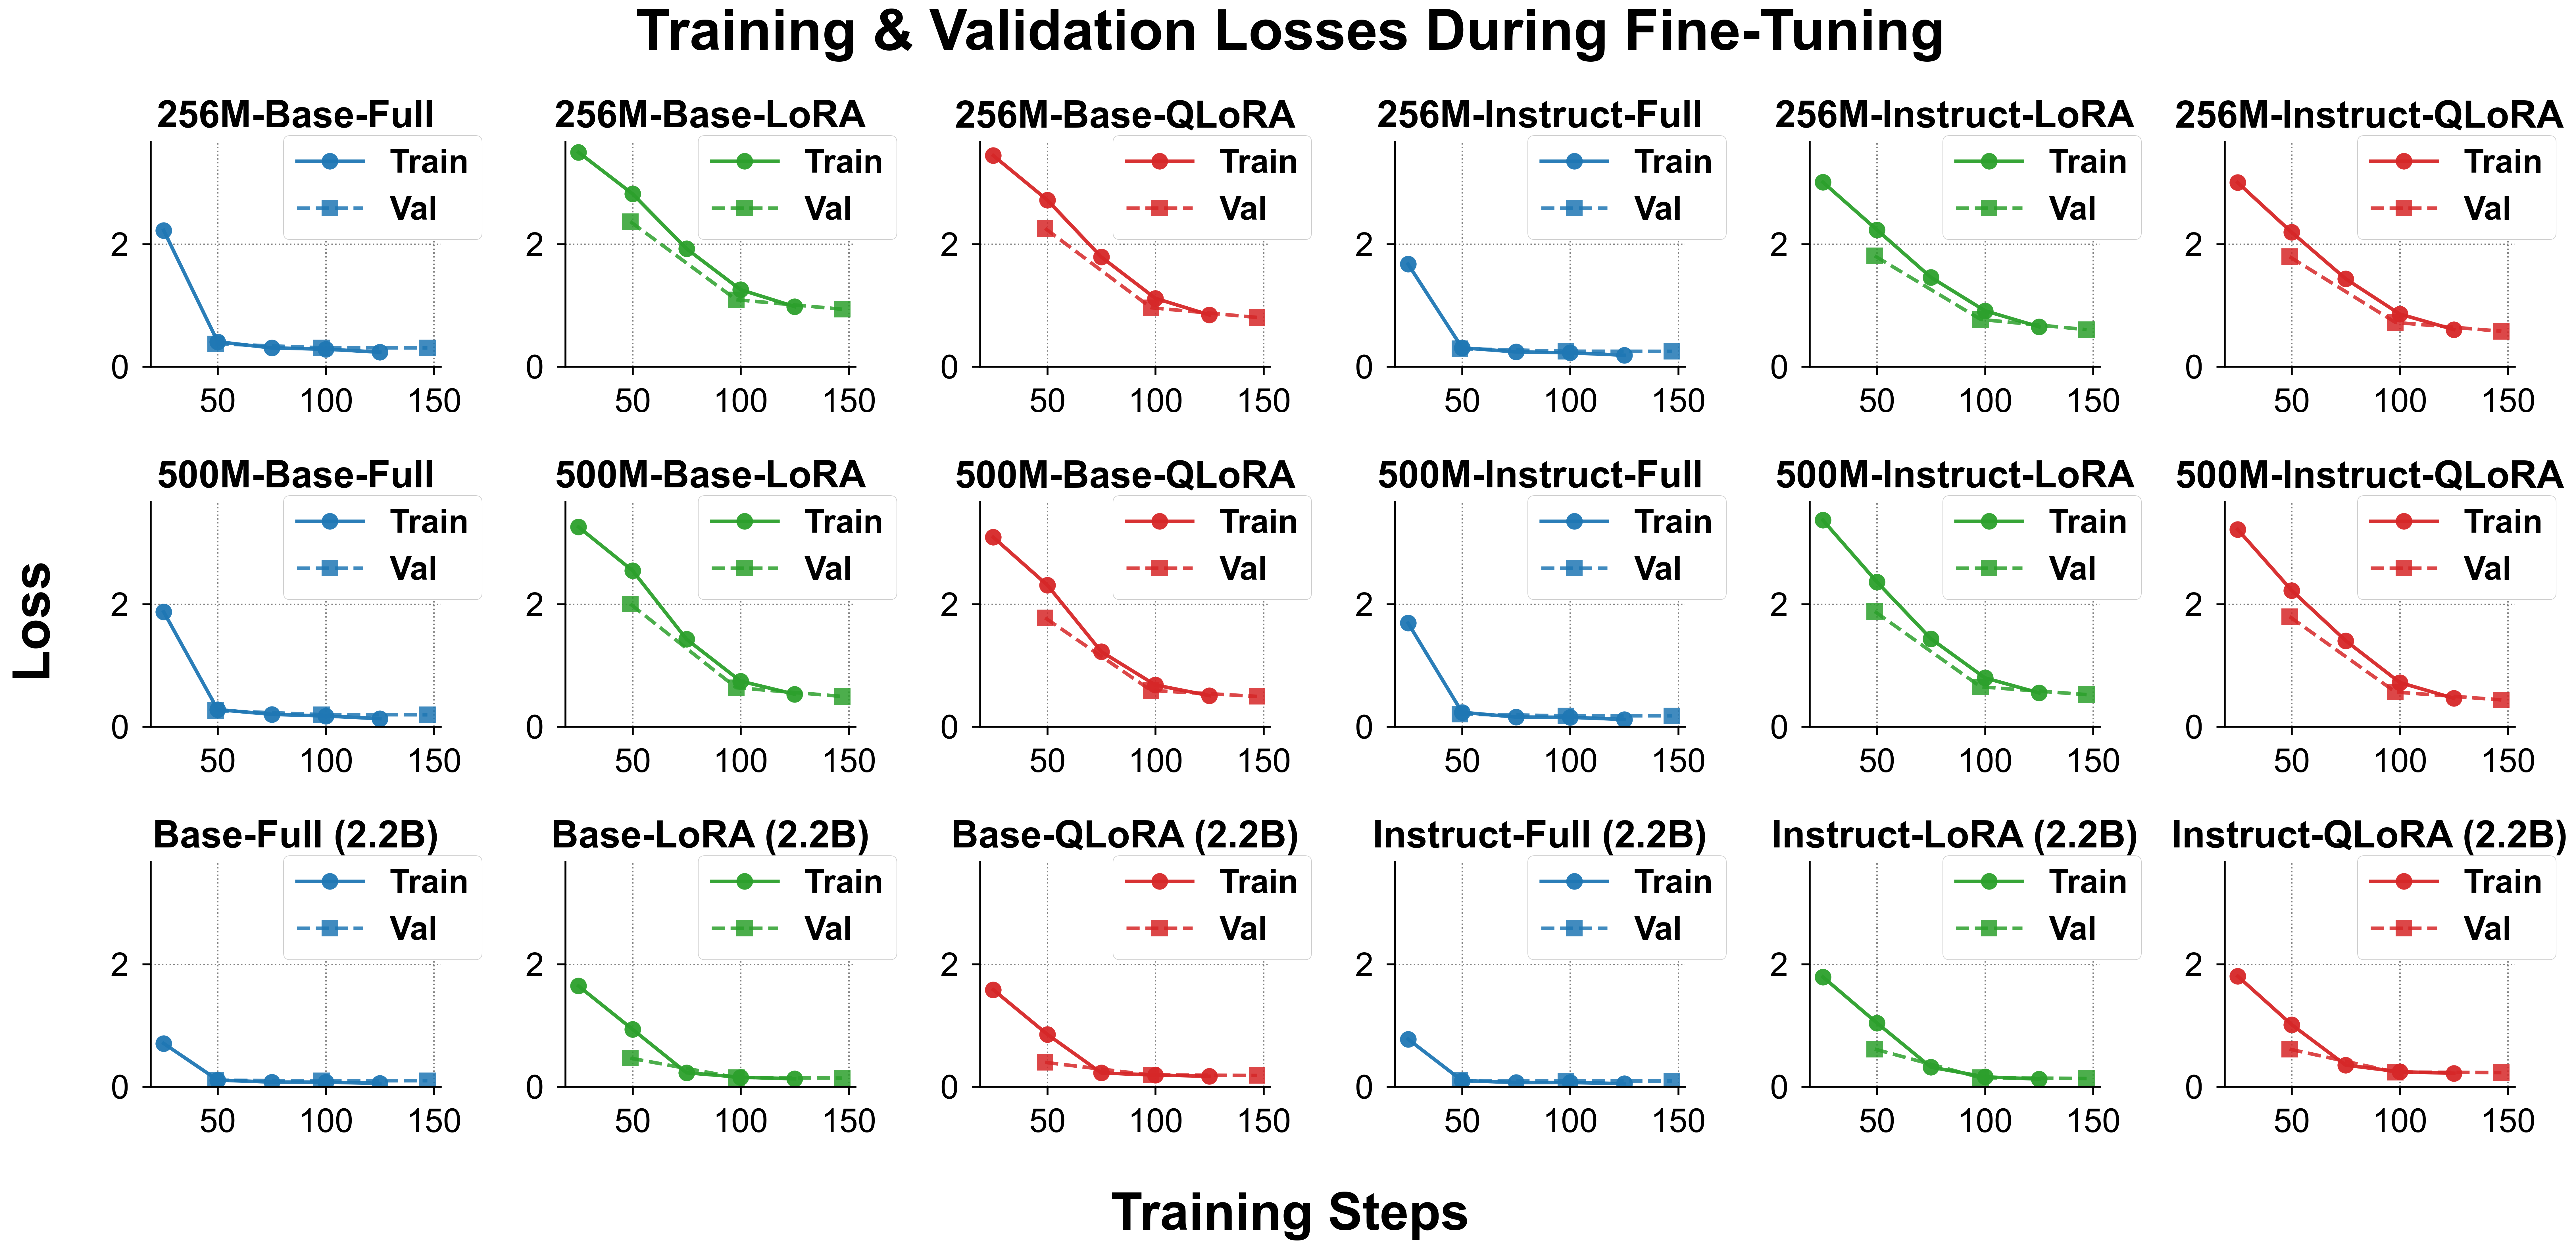

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
def load_runs(base_dir, prefix, filter_mode="base"):
    search_pattern = f"{prefix}*/trainer_state.json"
    state_files = list(base_dir.glob(search_pattern))

    if not state_files:
        raise FileNotFoundError("No trainer state files found.")

    run_data = []
    max_loss = 0

    for file_path in state_files:
        folder_name = file_path.parent.name
        run_label = folder_name.replace(f"{prefix}-", "")

        if filter_mode == "base":
            # Only folders like "SmolVLM-256M-Instruct-lora-tuned" (not extra-tuned)
            if not re.fullmatch(r".*-tuned", run_label):
                continue
        elif filter_mode == "finetuned":
            # Match folders with -tuned-xxx or _tuned_yyy or anything more than "-tuned"
            if re.fullmatch(r".*-tuned", run_label):
                continue
        else:
            raise ValueError("filter_mode must be 'base' or 'finetuned'")

        if "-full-" in folder_name:
            method = "Full"
        elif "-qlora-" in folder_name:
            method = "QLoRA"
        elif "-lora-" in folder_name:
            method = "LoRA"
        else:
            method = "LoRA"

        with open(file_path, "r") as f:
            log_history = json.load(f).get("log_history", [])

        df = pd.DataFrame(log_history)
        train_df = df[df["loss"].notna() & df["step"].notna()]
        val_df = df[df["eval_loss"].notna() & df["step"].notna()]

        if not train_df.empty:
            max_loss = max(max_loss, train_df["loss"].max())
        if not val_df.empty:
            max_loss = max(max_loss, val_df["eval_loss"].max())

        clean_label = re.sub(r"-tuned$", "", run_label)
        run_data.append((clean_label, train_df, val_df, method))

    run_data.sort(key=lambda x: x[0])
    return run_data, max_loss


def set_scientific_plot_style():
    """Set publication-quality plot style with advanced settings"""
    plt.style.use('seaborn-v0_8-paper')

    colors = sns.color_palette("viridis", 8)

    plt.rcParams.update({
        'font.family': 'arial',#serif
        #'font.serif': ['DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
        'font.size': 16,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.6,
        'lines.linewidth': 1.5,
        'lines.markersize': 5,
        'axes.prop_cycle': cycler('color', colors),
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        #'figure.figsize': (7, 6),
        'figure.dpi': 600,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
    })


def get_method_colors():
    """Return consistent colors by method type"""
    return {
        "Full": "#1f77b4",  # blue
        "LoRA": "#2ca02c",  # green
        "QLoRA": "#d62728"  # red
    }


def plot_runs(run_data, output_path, title="Loss Curves", figsize=None):
    if not run_data:
        print("No runs to plot.")
        return
    set_scientific_plot_style()
    method_colors = get_method_colors()
    ncols = min(6, len(run_data))
    nrows = math.ceil(len(run_data) / ncols)
    if figsize is None:
        figsize = (ncols * 3.2, nrows * 2.5)
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(nrows, ncols, figure=fig)
    y_min, y_max = float('inf'), float('-inf')

    axes = []
    for i, (label, train_df, val_df, method) in enumerate(run_data):
        row, col = i // ncols, i % ncols
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

        method_color = method_colors.get(method, "#ff7f0e")  

        if not train_df.empty:
            ax.plot(
                train_df["step"], train_df["loss"],
                label="Train",
                color=method_color,
                linestyle="-",
                marker="o",
                markersize=7,
                markevery=max(1, len(train_df)//8),
                alpha=0.95
            )
            y_min = min(y_min, train_df["loss"].min() * 0.95)
            y_max = max(y_max, train_df["loss"].max() * 1.05)

        if not val_df.empty:
            ax.plot(
                val_df["step"], val_df["eval_loss"],
                label="Val",
                color=method_color,
                linestyle="--",
                marker="s",
                markersize=7,
                markevery=max(1, len(val_df)//8),
                alpha=0.85
            )
            y_min = min(y_min, val_df["eval_loss"].min() * 0.95)
            y_max = max(y_max, val_df["eval_loss"].max() * 1.05)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))

        reduced_label = label[8:].replace("q","Q").replace("lora","LoRA").replace('full','Full')

        # Title for each plot
        if row == 2:
            reduced_label = reduced_label + " (2.2B)"
        ax.set_title(f"{reduced_label}", fontsize=16, pad=6, fontweight='bold',)

        #ax.text(0.97, 0.07, method,transform=ax.transAxes,fontsize=12,ha='right',va='center',
        #    bbox=dict(boxstyle='round,pad=0.3',facecolor=method_color,alpha=0.2,edgecolor=method_color,linewidth=0.5)
        #)
        legend_properties = {'weight':'bold'}
        ax.legend(['Train', 'Val'],bbox_to_anchor=(1.2, 1.1),loc='upper right',fontsize=16,framealpha=1, prop=legend_properties)
        ax.grid(True, linestyle=':', alpha=1, color='gray')

    if y_min != float('inf') and y_max != float('-inf'):
        for ax in axes:
            #ax.set_ylim(y_min, y_max)
            ax.set_ylim(0, y_max)

    for ax in axes[len(run_data):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=24, y=0.92, fontweight='bold',)
    
    fig.supxlabel("Training Steps", fontsize=22, y=0.07, fontweight='bold')
    fig.supylabel("Loss", fontsize=22, x=0.03,fontweight='bold')
    plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.95])
    
    #fig.text(0.98, 0.01, f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d')}",ha='right', va='bottom', fontsize=6, color='gray', alpha=0.7)

    fig.savefig(output_path, dpi=600, bbox_inches='tight')
    print(f"Enhanced plot saved to {output_path}")

    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            plt.show()
    except (ImportError, NameError):
        pass

    return fig


def aggregate_and_plot_loss_curves():
    print("--- Plotting Base Runs ---")
    run_data, _ = load_runs(BASE_OUTPUT_DIR, OUTPUT_FOLDER_PREFIX, filter_mode="base")
    output_path = BASE_OUTPUT_DIR / f"{OUTPUT_FOLDER_PREFIX}_base_loss_curves.pdf"

    fig = plot_runs(
        run_data,
        output_path,
        title="Training & Validation Losses During Fine-Tuning",
        figsize=(16,8.5)
    )

    png_path = output_path.with_suffix('.eps')
    fig.savefig(png_path, dpi=600)

    plt.close(fig)


def aggregate_and_plot_finetuned_loss_curves():
    print("--- Plotting Fine-tuned Runs ---")
    run_data, _ = load_runs(BASE_OUTPUT_DIR, OUTPUT_FOLDER_PREFIX, filter_mode="finetuned")
    output_path = BASE_OUTPUT_DIR / f"{OUTPUT_FOLDER_PREFIX}_finetuned_loss_curves.pdf"

    fig = plot_runs(
        run_data,
        output_path,
        title="Hyperparameter Tuning: Training & Validation Losses"
    )

    png_path = output_path.with_suffix('.png')
    fig.savefig(png_path, dpi=600)

    plt.close(fig)


# Run both plot functions
aggregate_and_plot_loss_curves() # for initial fine-tuning of Base and instruct models
# aggregate_and_plot_finetuned_loss_curves()